In [1]:
import pandas as pd
df  = pd.read_csv("SampleDataset.csv", encoding='latin-1')

In [2]:
df.head()

,Sno,TECHNOLOGY,ORIGINAL/SYNONYM,QUESTION,SOLUTION
0,1,PowerBI,Original,Issue with Power bi date slicer,If you are experiencing an issue with the date...
1,2,PowerBI,Synonym,What are some common issues that can arise wit...,same as above
2,3,PowerBI,Synonym,How do I resolve issues with the date slicer i...,Same as above
3,4,PowerBI,Synonym,I'm having trouble getting the date slicer in ...,Same as above
4,5,PowerBI,Synonym,What could be causing the date slicer in Power...,Same as above


In [3]:
# I only need column 2nd and 4th
df = df.iloc[:,[1,3]]

In [4]:
df.head()

,TECHNOLOGY,QUESTION
0,PowerBI,Issue with Power bi date slicer
1,PowerBI,What are some common issues that can arise wit...
2,PowerBI,How do I resolve issues with the date slicer i...
3,PowerBI,I'm having trouble getting the date slicer in ...
4,PowerBI,What could be causing the date slicer in Power...


In [5]:
# group the data based on column 1
data = df.groupby('TECHNOLOGY').count()

In [6]:
data.head()

,QUESTION
TECHNOLOGY,
Azure Analysis Services,90
Azure Data Factory,180
PowerBI,90


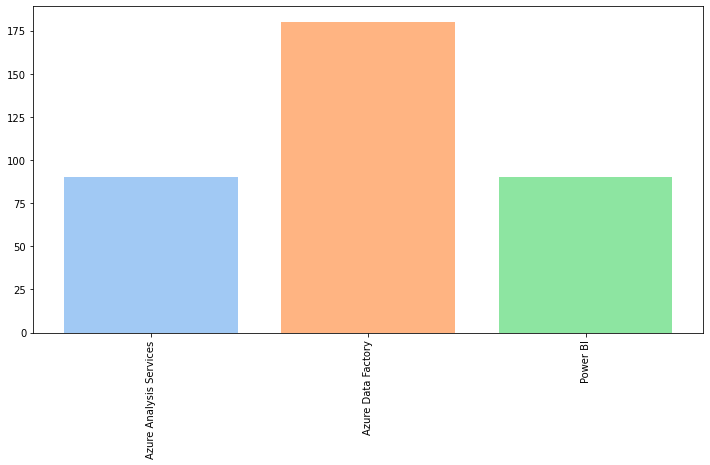

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the data
x = ['Azure Analysis Services', 'Azure Data Factory', 'Power BI']
y = data['QUESTION']
colors = sns.color_palette('pastel')
fig = plt.figure(figsize=(12, 6))
plt.bar(x, y, color=colors[:3])
# display the plot
plt.xticks(rotation=90)
plt.show()

In [8]:
possible_labels = df.TECHNOLOGY.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'PowerBI': 0, 'Azure Analysis Services': 1, 'Azure Data Factory': 2}

In [9]:
import collections

inverse_dict = collections.defaultdict(list)
for key, value in label_dict.items():
    inverse_dict[value].append(key)

In [10]:
df['TECHNOLOGY'].value_counts()

Azure Data Factory         180
PowerBI                     90
Azure Analysis Services     90
Name: TECHNOLOGY, dtype: int64

In [11]:
df['label'] = df.TECHNOLOGY.replace(label_dict)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['TECHNOLOGY', 'label', 'data_type']).count()

QUESTION
TECHNOLOGY              label data_type          
Azure Analysis Services 1     train            77
                              val              13
Azure Data Factory      2     train           153
                              val              27
PowerBI                 0     train            76
                              val              14

In [13]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

import warnings
warnings.filterwarnings("ignore")

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].QUESTION.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].QUESTION.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [15]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [16]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [17]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 6

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [18]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [19]:
import random
import numpy as np

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'data volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/102 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7296142534298056
Validation loss: 0.5528148752119806
F1 Score (Weighted): 0.802244968050954


Epoch 2:   0%|          | 0/102 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.41612679193563323
Validation loss: 0.27663400231136215
F1 Score (Weighted): 0.9001277347959271


Epoch 3:   0%|          | 0/102 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.1299954963135807
Validation loss: 0.21927581970683402
F1 Score (Weighted): 0.9425730994152047


Epoch 4:   0%|          | 0/102 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.04137911851627424
Validation loss: 0.07501743767513996
F1 Score (Weighted): 0.9621998371998371


Epoch 5:   0%|          | 0/102 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.017492603752579466
Validation loss: 0.045088422691656485
F1 Score (Weighted): 0.981306896121711


Epoch 6:   0%|          | 0/102 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.013044657167412486
Validation loss: 0.054262551142730646
F1 Score (Weighted): 0.9621998371998371


In [20]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

model.load_state_dict(torch.load('data volume/finetuned_BERT_epoch_6.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: PowerBI
Accuracy: 12/14

Class: Azure Analysis Services
Accuracy: 13/13

Class: Azure Data Factory
Accuracy: 27/27

